In [ ]:
#| default_exp core

# Core functionality

> Core functions

In [2]:

#hide
from nbdev.showdoc import *

In [3]:
#| export
import re

In [4]:
#| export
import transformers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from dataclasses import asdict
from collections import OrderedDict
from typing import Union, Tuple, Sequence, Set
from numpy.random import RandomState
import numpy as np
from datasets import Dataset
from datasets import load_dataset
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision.transforms import (
                                    RandomErasing,
                                    RandomAutocontrast,
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    RandomAdjustSharpness,
                                    ToTensor)
import torch
from transformers import AutoFeatureExtractor, TrainingArguments, Trainer
from transformers import AutoModelForImageClassification
from evaluate import load as load_metric
from rich import print
import re
from dataclasses import dataclass
from typing import Dict
import datasets
import pandas as pd
from scipy.special import softmax
from tqdm.auto import tqdm
from imagededup.methods import PHash
from PIL import Image

In [5]:
%%bash
git lfs update --force

Updated Git hooks.


testing

In [6]:
from numpy.testing import assert_allclose
from toolz.dicttoolz import valmap
from collections import Counter
from toolz import frequencies
from dotenv import load_dotenv
import os

In [ ]:
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

## Data loading

In [ ]:
# !git clone https://huggingface.co/datasets/davanstrien/testgitupload

In [10]:
testdataset = Path("testdataset")
testdataset.mkdir()

In [11]:
test_images = {"control": Image.open("testdata/add_ms_05422_fcontrol1.jpg"),
"flysheet": Image.open("testdata/add_ms_9403_fse001v.jpg")}

In [12]:
for label in {"control","flysheet"}:
    folder = testdataset/label
    folder.mkdir()
    image = test_images[label]
    for i in range(100):
        fname = f"{i}_{label}"
        image.save(f"{folder}/{fname}.jpg")

In [13]:
phasher = PHash()

In [14]:
encodings = phasher.encode_images(image_dir='testdataset')


2022-12-12 10:47:53,861: INFO Start: Calculating hashes...
0it [00:00, ?it/s]
2022-12-12 10:47:53,970: INFO End: Calculating hashes!


In [15]:
duplicates = phasher.find_duplicates(image_dir="testdataset", encoding_map=encodings)

2022-12-12 10:47:53,988: INFO Start: Calculating hashes...
0it [00:00, ?it/s]
2022-12-12 10:47:54,068: INFO End: Calculating hashes!
2022-12-12 10:47:54,069: INFO Start: Evaluating hamming distances for getting duplicates
2022-12-12 10:47:54,071: INFO Start: Retrieving duplicates using Cython Brute force algorithm
0it [00:00, ?it/s]
2022-12-12 10:47:54,157: INFO End: Retrieving duplicates using Cython Brute force algorithm
2022-12-12 10:47:54,159: INFO End: Evaluating hamming distances for getting duplicates


In [16]:
duplicates

{}

In [17]:
ds = load_dataset("imagefolder",data_dir="testdataset",
                  streaming=False,
                  split='train')

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Using custom data configuration default-2cddcb8c7d26937e


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /Users/dvanstrien/.cache/huggingface/datasets/imagefolder/default-2cddcb8c7d26937e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [18]:
ds

Dataset({
    features: ['image', 'label'],
    num_rows: 200
})

In [19]:
ds[0]['image'].filename

'/Users/dvanstrien/Documents/DS/gym/nbs/testdataset/control/0_control.jpg'

In [20]:
#| export
def filter_bad_images(ds: Dataset):
    idx = list(range(len(ds)))
    for i in tqdm(idx):
        try:
            if isinstance(ds[i]['image'], Image.Image):
                continue
            else:
                idx.pop(i)
        except OSError:
            idx.pop(i)
    return ds.select(idx)


In [21]:
ds = filter_bad_images(ds)

  0%|          | 0/200 [00:00<?, ?it/s]

In [22]:
ds

Dataset({
    features: ['image', 'label'],
    num_rows: 200
})

In [23]:
#| export
def get_fpath(ds: Dataset):
   return ds.map(lambda x: {'fpath': x['image'].filename})

In [24]:
ds = get_fpath(ds)

  0%|          | 0/200 [00:00<?, ?ex/s]

In [25]:
ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=687x1000>,
 'label': 0,
 'fpath': '/Users/dvanstrien/Documents/DS/gym/nbs/testdataset/control/0_control.jpg'}

In [26]:
f =  '/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r (1).jpg.jpg'

In [27]:
f

'/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r (1).jpg.jpg'

In [28]:
f = re.sub(r"(\(\d\))","",f)

In [29]:
f.split('.')[0]

'/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r/Users/dvanstrien/Documents/DS/hmd_flysheet_detection/data/Flysheet_data/CONTAINER/or_5268_fse002r '

In [30]:
#| export
def return_base_path_deduplicated(x):
    f = x['fpath']
    f = re.sub(r"(\(\d\))","",f)
    f = f.split(".")[0]
    f = f.rstrip()
    return {"clean_path": re.sub(r"(\(\d\))","",f)}

In [31]:
#| export
def check_uniques(example, uniques, column='clean_path'):
    if example[column] in uniques:
        uniques.remove(example[column])
        return True
    else:
        return False

In [32]:
#| export
def drop_duplicates(ds):
    ds = ds.map(return_base_path_deduplicated)
    uniques = set(ds['clean_path'])
    ds = ds.filter(check_uniques, fn_kwargs={"uniques":uniques})
    return ds

In [33]:
ds = drop_duplicates(ds)

  0%|          | 0/200 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [34]:
ds

Dataset({
    features: ['image', 'label', 'fpath', 'clean_path'],
    num_rows: 200
})

In [35]:
#| export
def get_id(example):
    x = example["fpath"]
    x = Path(x).name.split("_")
    return {"id": "_".join(x[:2] if len(x) >= 3 else x[:3])}

## Train, valid, test splits

In [36]:
#| export
def split_w_stratify(
    ds,
    test_size: Union[int, float],
    random_state: Union[int, RandomState, None] = None,
) -> Tuple[Dataset, Dataset]:
    labels = ds['label']
    label_array = np.array(labels)
    train_inds, valid_inds = next(
        StratifiedShuffleSplit(
            n_splits=3, test_size=test_size, random_state=random_state
        ).split(np.zeros(len(labels)), y=label_array)
    )
    return ds.select(train_inds), ds.select(valid_inds)

In [37]:
train, valid = split_w_stratify(ds, test_size=0.5)

test frequencies 

In [38]:
assert_allclose(train.shape, valid.shape,rtol=2)

In [39]:
train_freqs = frequencies(train['label'])
train_freqs

{1: 50, 0: 50}

In [40]:
train_percentages =  OrderedDict(sorted(valmap(lambda x: x/len(train_freqs),train_freqs).items())).values()
train_percentages

odict_values([25.0, 25.0])

In [41]:
valid_freqs = frequencies(valid['label'])
valid_percentages = OrderedDict(sorted(valmap(lambda x: x/len(valid_freqs),valid_freqs).items())).values()
valid_percentages

odict_values([25.0, 25.0])

In [42]:
assert_allclose(list(train_percentages), list(valid_percentages), atol=1)

In [43]:
#| export
def train_valid_split_w_stratify(
    ds,
    valid_size: Union[int,float]=None,
    test_size: Union[int, float]=0.2,
    train_size: Union[int, float, None] = None,
    random_state: Union[int, RandomState, None] = None,
) -> Tuple[Dataset,Dataset, Dataset]:
    train, valid_test = split_w_stratify(ds, test_size=test_size)
    valid, test = split_w_stratify(valid_test, test_size=0.1)
    return train, valid, test

In [44]:
train, valid, test = train_valid_split_w_stratify(ds)

In [45]:
#| export
def prepare_dataset(ds):
    print("Preparing dataset...")
    print("dropping duplicates...")
    ds = filter_bad_images(ds)
    # ds = get_fpath(ds)
    # ds = drop_duplicates(ds)
    # print("getting ID...")
    # ds = ds.map(get_id)
    print("creating train, valid, test splits...")
    train, valid, test = train_valid_split_w_stratify(ds)
    data = {"train": train,
            "valid": valid,
            "test": test}
    for k,v  in data.items():
        print(f"{k} has {len(v)} examples")
    return train,valid,test

In [46]:
ds = load_dataset("imagefolder",data_dir="testdataset",
                  split='train',use_auth_token=True)

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Using custom data configuration default-2cddcb8c7d26937e
Found cached dataset imagefolder (/Users/dvanstrien/.cache/huggingface/datasets/imagefolder/default-2cddcb8c7d26937e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


In [47]:
train,valid,test = prepare_dataset(ds)
train,valid,test

Preparing dataset...

dropping duplicates...

  0%|          | 0/200 [00:00<?, ?it/s]

creating train, valid, test splits...

train has 160 examples

valid has 36 examples

test has 4 examples

(Dataset({
     features: ['image', 'label'],
     num_rows: 160
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 36
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 4
 }))

## Augmentations

In [48]:
model_checkpoint = "davanstrien/vit-base-patch16-224-in21k-base-manuscripts"


In [49]:
#| export
def prepare_transforms(model_checkpoint, train_ds, valid_ds, test_ds=None):
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
    normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
    _train_transforms = Compose(
            [
                Resize((feature_extractor.size['height'],feature_extractor.size['width'])),
                RandomAdjustSharpness(0.1),
                RandomAutocontrast(),
                ToTensor(),
                normalize,
                RandomErasing()
            ]
        )

    _val_transforms = Compose(
            [
                Resize((feature_extractor.size['height'],feature_extractor.size['width'])),
                ToTensor(),
                normalize,
            ]
        )

    def train_transforms(examples):
        examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
        return examples

    def val_transforms(examples):
        examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
        return examples
    if test_ds is not None:
        test_ds.set_transform(val_transforms)
    train_ds.set_transform(train_transforms)
    valid_ds.set_transform(val_transforms)
    return train_ds, valid_ds, test_ds

In [50]:
train_ds, valid_ds, test_ds = prepare_transforms(model_checkpoint, train,valid, test)

In [51]:
#| export
@dataclass
class FlyswotData:
    train_ds: datasets.arrow_dataset.Dataset
    valid_ds: datasets.arrow_dataset.Dataset
    test_ds: datasets.arrow_dataset.Dataset
    id2label: Dict[int,str]
    label2id: Dict[str,int]

In [52]:
#| export
def prep_data(ds, model_checkpoint=None):
    try:
        labels = ds.features['label'].names
        id2label = dict(enumerate(labels))
        label2id = {v:k for k,v in id2label.items()}
        train, valid, test = prepare_dataset(ds)
        train_ds, valid_ds, test_ds = prepare_transforms(model_checkpoint, train, valid, test)
        return FlyswotData(train_ds, valid_ds, test_ds, id2label, label2id)
    except FileNotFoundError as e:
        print(f"{e} make sure you are logged into the Hugging Face Hub")

In [58]:
data = prep_data(ds, model_checkpoint=model_checkpoint)

Preparing dataset...

dropping duplicates...

  0%|          | 0/994 [00:00<?, ?it/s]

creating train, valid, test splits...

train has 795 examples

valid has 179 examples

test has 20 examples

FlyswotData(train_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 795
}), valid_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 179
}), test_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 20
}), id2label={0: 'CONTAINER', 1: 'CONTROL%20SHOT', 2: 'COVER', 3: 'EDGE%20%2B%20SPINE', 4: 'FLYSHEET', 5: 'OTHER', 6: 'PAGE%20%2B%20FOLIO', 7: 'SCROLL'}, label2id={'CONTAINER': 0, 'CONTROL%20SHOT': 1, 'COVER': 2, 'EDGE%20%2B%20SPINE': 3, 'FLYSHEET': 4, 'OTHER': 5, 'PAGE%20%2B%20FOLIO': 6, 'SCROLL': 7})

In [59]:
data

FlyswotData(train_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 795
}), valid_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 179
}), test_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 20
}), id2label={0: 'CONTAINER', 1: 'CONTROL%20SHOT', 2: 'COVER', 3: 'EDGE%20%2B%20SPINE', 4: 'FLYSHEET', 5: 'OTHER', 6: 'PAGE%20%2B%20FOLIO', 7: 'SCROLL'}, label2id={'CONTAINER': 0, 'CONTROL%20SHOT': 1, 'COVER': 2, 'EDGE%20%2B%20SPINE': 3, 'FLYSHEET': 4, 'OTHER': 5, 'PAGE%20%2B%20FOLIO': 6, 'SCROLL': 7})

In [60]:
from dataclasses import asdict

In [61]:
train_ds, valid_ds, test_ds, id2label, label2id = asdict(data).values()

In [62]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 795
})

## Model training

In [63]:
#| export
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [64]:
#| export
from sklearn.metrics import classification_report

In [65]:
#| export
def train_model(data, 
                model_checkpoint,
                num_epochs=50,
                hub_model_id="flyswot",
                tune=False,
               fp16=True):
    transformers.logging.set_verbosity_warning()
    train_ds, valid_ds, test_ds, id2label, label2id = asdict(data).values()
    print(train_ds)
    model = AutoModelForImageClassification.from_pretrained(model_checkpoint, num_labels=len(id2label),
                                                   id2label=id2label,
                                                  label2id=label2id, ignore_mismatched_sizes=True)
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
    args = TrainingArguments(
    "output_dir",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    hub_model_id=f"flyswot/{hub_model_id}",
    overwrite_output_dir=True,
    push_to_hub=False,
    learning_rate=2e-5,
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=4,
    num_train_epochs=num_epochs,
    weight_decay=0.1,disable_tqdm=False,
    fp16=fp16,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir='logs',
    remove_unused_columns=False,
    save_total_limit=10,
    optim="adamw_torch",
    seed=42,    
)
    def compute_metrics(eval_pred):
        precision_metric = load_metric("precision")
        recall_metric = load_metric("recall")
        f1_metric = load_metric("f1")
        accuracy_metric = load_metric("accuracy")

        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        precision = precision_metric.compute(predictions=predictions, references=labels,average='macro')["precision"]
        recall = recall_metric.compute(predictions=predictions, references=labels,average='macro')["recall"]
        f1 = f1_metric.compute(predictions=predictions, references=labels,average='macro')['f1']
        accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
        return {"precision": precision, "recall": recall, "f1":f1, "accuracy":accuracy}

    trainer = Trainer(model,
                      args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor)
    trainer.train()
    return trainer

In [66]:
trainer = train_model(data, "facebook/deit-tiny-patch16-224",0.001, fp16=False, hub_model_id='test')

Dataset({
    features: ['image', 'label'],
    num_rows: 795
})

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([8, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
***** Running training *****
  Num examples = 795
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 1
  Number of trainable parameters = 5525960


Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 179
  Batch size = 4
/Users/dvanstrien/Documents/DS/gym/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to output_dir/checkpoint-1
Configuration saved in output_dir/checkpoint-1/config.json
Model weights saved in output_dir/checkpoint-1/pytorch_model.bin
Image processor saved in output_dir/checkpoint-1/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output_dir/checkpoint-1 (score: 0.20914715701875866).


## Model management

In [67]:
data

FlyswotData(train_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 795
}), valid_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 179
}), test_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 20
}), id2label={0: 'CONTAINER', 1: 'CONTROL%20SHOT', 2: 'COVER', 3: 'EDGE%20%2B%20SPINE', 4: 'FLYSHEET', 5: 'OTHER', 6: 'PAGE%20%2B%20FOLIO', 7: 'SCROLL'}, label2id={'CONTAINER': 0, 'CONTROL%20SHOT': 1, 'COVER': 2, 'EDGE%20%2B%20SPINE': 3, 'FLYSHEET': 4, 'OTHER': 5, 'PAGE%20%2B%20FOLIO': 6, 'SCROLL': 7})

## Model Evaluation 

In [68]:
outputs = trainer.predict(data.test_ds)

***** Running Prediction *****
  Num examples = 20
  Batch size = 4


/Users/dvanstrien/Documents/DS/gym/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
outputs.metrics

{'test_loss': 1.9036948680877686,
 'test_precision': 0.20238095238095236,
 'test_recall': 0.16666666666666666,
 'test_f1': 0.18095238095238095,
 'test_accuracy': 0.3,
 'test_runtime': 12.3261,
 'test_samples_per_second': 1.623,
 'test_steps_per_second': 0.406}

In [72]:
#| export
def plot_confusion_matrix(outputs, trainer):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(15, 15))
    y_true = outputs.label_ids
    y_pred = outputs.predictions.argmax(1)
    labels =trainer.model.config.id2label.values()
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, ax=ax)


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (8).

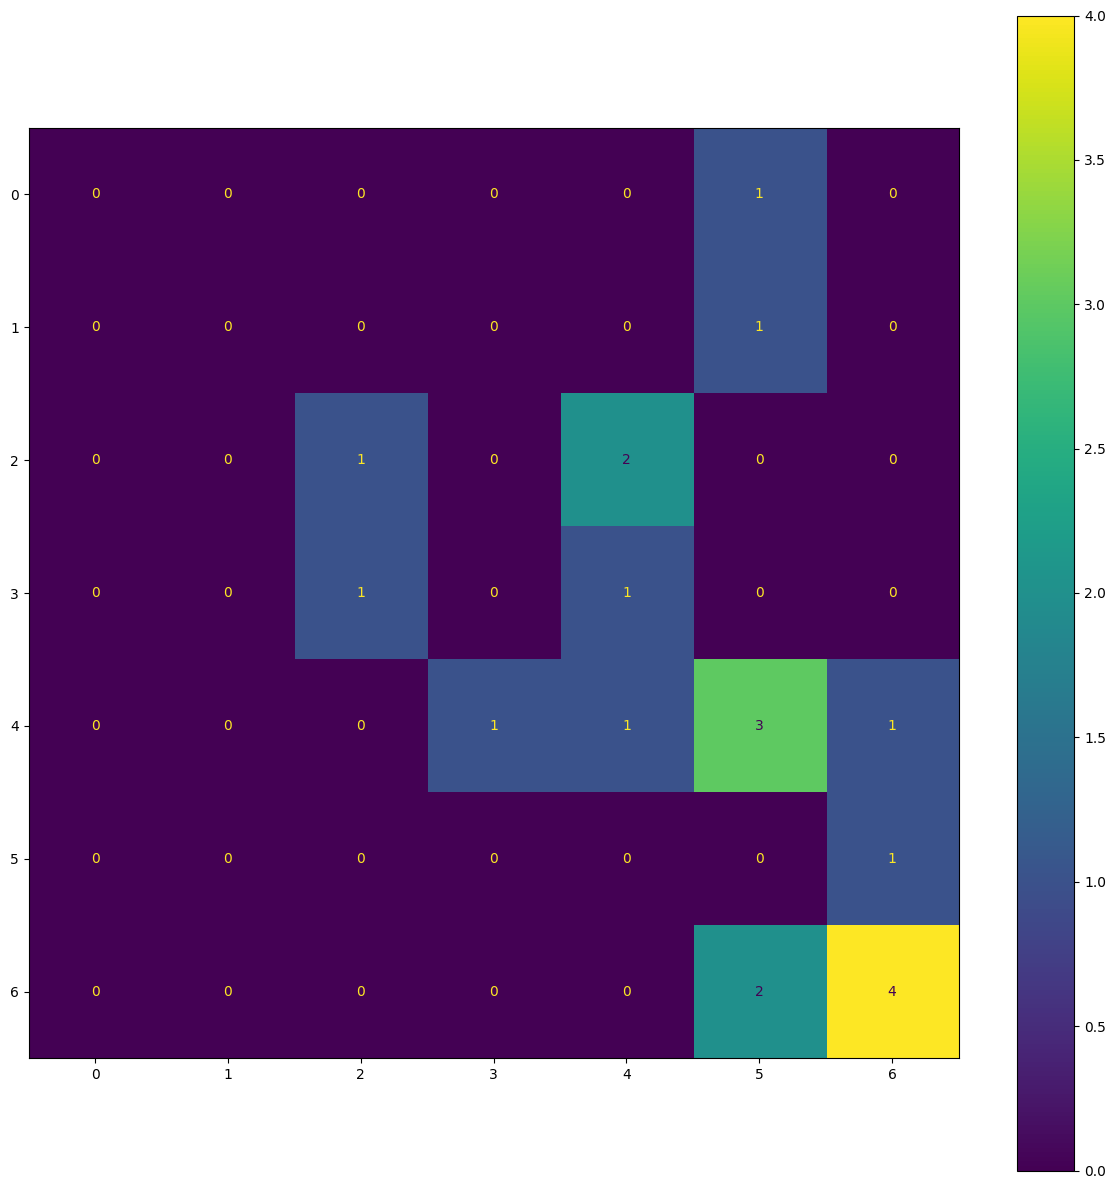

In [73]:
plot_confusion_matrix(outputs,trainer)

In [74]:
#| export
def create_classification_report(outputs, trainer):
    from sklearn.metrics import classification_report
    y_true = outputs.label_ids
    y_pred = outputs.predictions.argmax(1)
    labels =trainer.model.config.id2label.values()
    return classification_report(y_true, y_pred, target_names=labels, output_dict=True)

In [75]:
results = create_classification_report(outputs, trainer)

ValueError: Number of classes, 7, does not match size of target_names, 8. Try specifying the labels parameter

In [ ]:
results

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
# kwargs = {
#         "tasks": "image-classification",
#         "tags": ["image-classification", "vision"],
#     }
   
# #trainer.push_to_hub(**kwargs)

In [ ]:
# misclasified report

In [ ]:
data.test_ds[0]['image']

In [ ]:
#| export
def create_test_results_df(outputs, trainer, important_label=None, print_results=True, return_df=False) -> pd.DataFrame:
    id2label = trainer.model.config.id2label
    y_true = outputs.label_ids
    y_pred = outputs.predictions.argmax(1)
    y_prob = softmax(outputs.predictions, axis=1)
   # ids = test_data['id']
    df = pd.DataFrame({"y_true":y_true,"y_pred": y_pred, "y_prob": y_prob.max(1)})
    df.y_true = df.y_true.map(id2label)
    df.y_pred = df.y_pred.map(id2label)
    if print_results:
        misclassified_df = df[df.y_true != df.y_pred]
        print('misclasified:')
        print(misclassified_df)
        print('\n')
        if important_label:
            print(f"Number of wrong predictions of {important_label} label: {len(misclassified_df[misclassified_df['y_pred']==important_label])}")
            print(f"Percentage of wrong predictions of {important_label} label: {(len(misclassified_df[misclassified_df['y_pred']==important_label])/len(df))*100}")
    if return_df:
        return df


In [ ]:
df = create_test_results_df(outputs, trainer, print_results=True,return_df=True)

In [ ]:
# #export
# @pn.depends(index_selection)
# def get_image(selection):
#     id2label = trainer.config.id2label
#     image = flyswot_data.test_ds[selection]['image']
#     image = pn.Pane(image)
#     row = flyswot_data.test_ds[selection]
#     string_label = id2label[row['label']]
#    # label =  pn.pane.Markdown(f"""actual label: **{string_label}**""")
#     df_row = df.iloc[selection]
#     r = pn.Row(image, pn.Pane(df_row))
#     return r

In [ ]:
#| export
def create_mistakes_image_navigator(test_results_df, flyswot_data,trainer):
    import panel as pn
    pn.extension()
    df = test_results_df
    mistakes = df.y_true!=df.y_pred
    mistake_ids = df.index[mistakes].tolist()
    df = df[mistakes]
    df = df.reset_index(drop=True)
    subset = flyswot_data.test_ds.select(mistake_ids)
    assert len(df) == len(subset)
    if len(df)<1:
        print(df)
        return subset['image'][0]
    index_selection = pn.widgets.DiscreteSlider(options=df.index.to_list())
    id2label = trainer.model.config.id2label
    @pn.depends(index_selection)
    def get_image(selection):
        image = subset[selection]['image']
        image = pn.Pane(image)
        #row = flyswot_data.test_ds[selection]
       # string_label = id2label[row['label']]
       # label =  pn.pane.Markdown(f"""actual label: **{string_label}**""")
        df_row = df.iloc[selection]
        r = pn.Row(image, pn.Pane(df_row))
        return r
    df = df.reset_index(drop=True)
    return pn.Column(index_selection,get_image)

In [ ]:
# explorer = create_mistakes_image_navigator(df, data,trainer)

In [ ]:
# explorer

In [ ]:
# assert explorer

In [ ]:
# index_selection = pn.widgets.DiscreteSlider(options=df.index.to_list())

In [ ]:
# df = df.reset_index(drop=True)

In [ ]:
#| export
def create_misclassified_report(outputs, trainer, test_data, important_label=None, print_results=True, return_df=False):
    id2label = trainer.model.config.id2label
    y_true = outputs.label_ids
    y_pred = outputs.predictions.argmax(1)
    y_prob = softmax(outputs.predictions, axis=1)
    df = pd.DataFrame({"y_true":y_true,"y_pred": y_pred, "y_prob": y_prob.max(1)})
    df.y_true = df.y_true.map(id2label)
    df.y_pred = df.y_pred.map(id2label)
    if print_results:
        misclassified_df = df[df.y_true != df.y_pred]
        print('misclasified:')
        print(misclassified_df)
        print('\n')
        if important_label:
            print(f"Number of wrong predictions of {important_label} label: {len(misclassified_df[misclassified_df['y_pred']==important_label])}")
            print(f"Percentage of wrong predictions of {important_label} label: {(len(misclassified_df[misclassified_df['y_pred']==important_label])/len(df))*100}")
    if return_df:
        return misclassified_df


In [ ]:
assert isinstance(df, pd.DataFrame)

In [ ]:
df.y_prob.max()

In [ ]:
df[df['y_pred']=='FLYSHEET']

In [ ]:
df[df['y_pred']=='FLYSHEET'].sort_values('y_prob',ascending=False)

In [ ]:
#trainer.push_to_hub()

In [ ]:
#import pandas as pd

In [ ]:
# y_true = outputs.label_ids
# y_pred = outputs.predictions.argmax(1)
# df = pd.DataFrame({"y_true":y_true,"y_pred": y_pred})

In [ ]:
#tidy 

In [76]:
import shutil 
shutil.rmtree("output_dir")
shutil.rmtree("testdataset")